## Gohar Nissa Fatima
**Assignment 1, Task 2**

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, to_date, countDistinct, udf, date_format, max as s_max, min as s_min
from pyspark.sql.types import FloatType
from scipy.spatial import distance

In [3]:
from matplotlib import pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import pandas as pd

In [6]:
spark = SparkSession.builder.getOrCreate()

In [7]:
df = spark.read.options(header=True, inferSchema=True).csv('raw\covid.csv')

#### Data Exploration

In [8]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- infection_status: string (nullable = true)
 |-- days_since_infection: double (nullable = true)
 |-- date_of_infection: timestamp (nullable = true)
 |-- date_of_symptoms: timestamp (nullable = true)
 |-- date_of_recovery: timestamp (nullable = true)
 |-- date_of_death: timestamp (nullable = true)
 |-- date_hospital_check_in: timestamp (nullable = true)
 |-- date_hospital_check_out: timestamp (nullable = true)
 |-- residence_id: integer (nullable = true)
 |-- school_id: integer (nullable = true)
 |-- workplace_id: integer (nullable = true)
 |-- currentLocationID: integer (nullable = true)
 |-- currentLocationType: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- zone_id: integer (nullable = true)
 |-- is_notified_to_isolate: integer (nullabl

In [9]:
# create a date column
df = df.withColumn("date", to_date(col("Date_Time"), "yyyy-MM-dd"))

In [10]:
# sneak-peak at data
df.limit(5).toPandas()

,_c0,Date_Time,id,age,gender,infection_status,days_since_infection,date_of_infection,date_of_symptoms,date_of_recovery,...,transmitted_count,asymptomatic_transmission,locationID_of_infection,income,household_size,bmi,date_of_test,test_result,Scenario,date
0,0,2020-01-01,32645,29,1,susceptible,0.0,None,None,None,...,0,-1,-1,5774.248719,6,25,None,-1,0000001_20200922055707,2020-01-01
1,1,2020-01-01,20022,30,1,susceptible,0.0,None,None,None,...,0,-1,-1,14384.879182,1,24,None,-1,0000001_20200922055707,2020-01-01
2,2,2020-01-01,18409,32,0,susceptible,0.0,None,None,None,...,0,-1,-1,9502.567895,4,24,None,-1,0000001_20200922055707,2020-01-01
3,3,2020-01-01,34113,29,1,susceptible,0.0,None,None,None,...,0,-1,-1,7029.974753,5,20,None,-1,0000001_20200922055707,2020-01-01
4,4,2020-01-01,40168,58,1,susceptible,0.0,None,None,None,...,0,-1,-1,12378.711455,2,31,None,-1,0000001_20200922055707,2020-01-01


In [11]:
# size and cols
print((df.count(), len(df.columns)))

(6800000, 43)


In [12]:
# a look into a user's data
df.select(['Date_Time', 'date', 'id', 'infection_status']).where(col('id') == '32645').limit(15).toPandas()

,Date_Time,date,id,infection_status
0,2020-01-01 00:00:00,2020-01-01,32645,susceptible
1,2020-01-01 08:00:00,2020-01-01,32645,susceptible
2,2020-01-01 16:00:00,2020-01-01,32645,susceptible
3,2020-01-01 19:00:00,2020-01-01,32645,susceptible
4,2020-01-01 22:00:00,2020-01-01,32645,susceptible
5,2020-01-02 00:00:00,2020-01-02,32645,susceptible
6,2020-01-02 08:00:00,2020-01-02,32645,susceptible
7,2020-01-02 16:00:00,2020-01-02,32645,susceptible
8,2020-01-02 19:00:00,2020-01-02,32645,susceptible
9,2020-01-02 22:00:00,2020-01-02,32645,susceptible


#### Q1: Plot the total number of infections, recoveries and deaths w.r.t date?

In [13]:
# select subset of columns
q1 = df.select(['id', 'date', 'infection_status']).dropDuplicates()

In [14]:
# group by infection status
q1_agg_pdf = q1.groupBy(['date', 'infection_status']).agg(countDistinct('id').alias('people')).toPandas()

In [15]:
# susceptible is not needed
q1_agg_pdf = q1_agg_pdf[q1_agg_pdf['infection_status'] != 'susceptible']

In [16]:
# fix type
q1_agg_pdf['date'] = q1_agg_pdf['date'].apply(pd.to_datetime)

In [17]:
# sort
q1_agg_pdf.sort_values('date', inplace=True)

d:\workplace\environments\bigdata\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([737425., 737446., 737456., 737477., 737485., 737506., 737516.,
        737537., 737546.]), <a list of 9 Text xticklabel objects>)

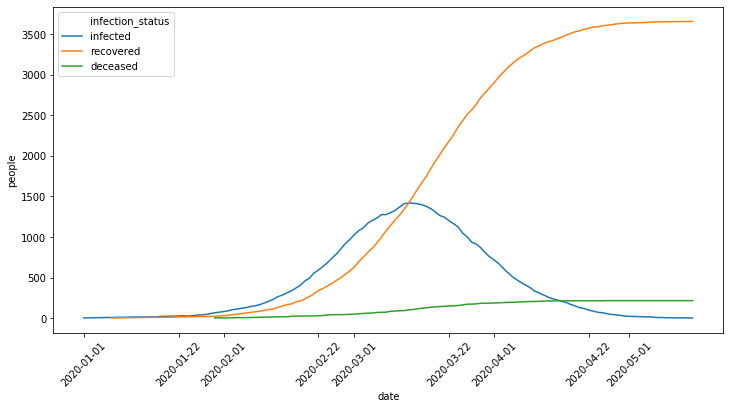

In [18]:
# visualize

plt.figure(figsize=(12,6))
ax = sns.lineplot(x="date", y="people", hue="infection_status", data=q1_agg_pdf)
plt.xticks(rotation=45)

#### Q2: Plot a pie chart for the ratio of asymptomatic and symptomatic infections

In [19]:
# filter for infections

infections = df.select(['id', 'is_symptomatic', 'infection_status']).where(col('infection_status') == 'infected')

In [20]:
# aggregate
is_symptomatic = infections.groupBy('is_symptomatic').agg(countDistinct('id').alias('people')).toPandas()

In [21]:
is_symptomatic

,is_symptomatic,people
0,1,2651
1,0,3854


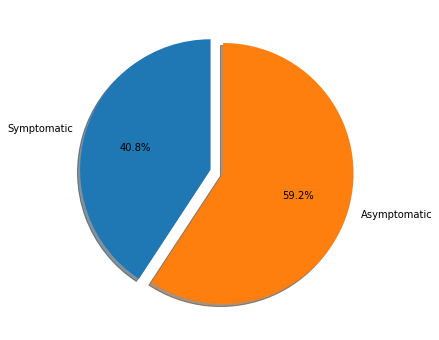

In [22]:
# visualize

plt.figure(figsize=(12,6))
ax = plt.pie(is_symptomatic['people'], 
             labels=['Symptomatic', 'Asymptomatic'], 
             explode=(0, 0.1), 
             autopct='%1.1f%%', 
             shadow=True, 
             startangle=90)

#### Q3: Plot the variation of proximity of individual (ID=37415) w.r.t date.

Assumptions

* only date is to be considered while calculating proximity
* questions is sort of pointed at knowing the variation of total number of people that a person was around at any location at any time of day 

In [23]:
user_id = 37415

In [24]:
# filter for user data

user_data = df.select(['id', 'date', 'currentLocationID', 'currentLocationType']).where(col('id') == user_id)

In [25]:
# prepare table to join

temp_df = df.select(['id', 'date', 'currentLocationID', 'currentLocationType'])

In [26]:
# join with full data to pick all people who shared location with 37415 on a date at any time
joined = user_data.alias('user').join(temp_df.alias('proximity'), on=['date', 'currentLocationID', 'currentLocationType'], how='inner')

In [27]:
# take count, i.e. aggregate
proximity_pdf = joined.groupBy(['user.date', 'user.currentLocationID', 'user.currentLocationType']).agg(countDistinct('proximity.id').alias('proximity')).toPandas()

In [28]:
proximity_pdf.sort_values('date', inplace=True)

In [29]:
proximity_pdf.head()

,date,currentLocationID,currentLocationType,proximity
147,2020-01-01,3628,shopping_mall,100
232,2020-01-01,3000,residential,4
203,2020-01-01,3690,employment,5
237,2020-01-02,3690,employment,5
186,2020-01-02,4796,market,109


In [30]:
proximity_pdf.shape

(359, 4)

In [31]:
# day-level calculation
final_proximity = proximity_pdf.groupby('date')['proximity'].sum()

Text(0.5, 1.0, 'Proximity for 37415 w.r.t date')

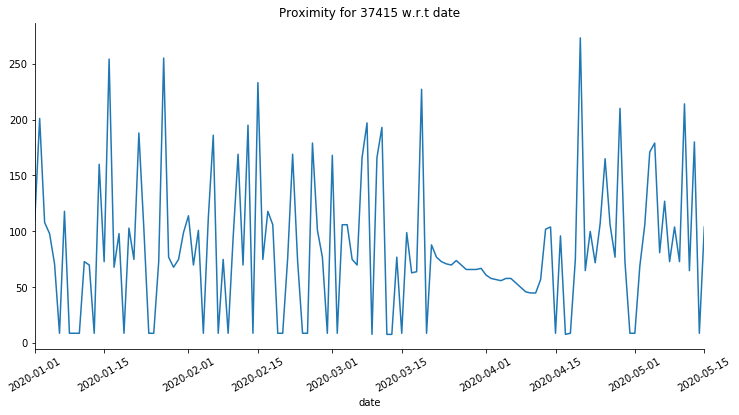

In [32]:
# visulize

plt.figure(figsize=(12,6))
ax = final_proximity.plot()
plt.xticks(rotation=30)
sns.despine()
plt.title('Proximity for {} w.r.t date'.format(user_id))

#### Q4:  Plot bar graphs to show the mortality rates and infection rates per age groups (create age groups 0-10, 10-20, and so on).

In [33]:
age = df.select(['id', 'age', 'infection_status'])

_**Age**_

In [34]:
# group by age and infection status
age_pdf = age.groupBy(['age', 'infection_status']).agg(countDistinct('id').alias('people')).toPandas()

In [35]:
# sort data just to make more sense
age_pdf.sort_values(by='age', inplace=True)

In [36]:
# pivot in order to compute mortality rate
age_pdf = age_pdf.pivot(index='age', columns='infection_status', values='people')

In [37]:
# fill blanks with 0, just to simplify
age_pdf.fillna(0, inplace=True)
age_pdf.reset_index(inplace=True)
age_pdf.rename_axis("index", axis="columns", inplace=True)

In [38]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_pdf['age_bin'] = pd.cut(age_pdf['age'], bins=bins)

In [39]:
final = age_pdf.groupby('age_bin', as_index=False).agg({'susceptible':'sum', 'infected':'sum', 'deceased':'sum'})

In [40]:
# claculate deceased ratio or mortality rate
final['infection_rate'] = (final['infected'] / final['susceptible']) * 100

In [41]:
# claculate deceased ratio or mortality rate
final['mortality_rate'] = (final['deceased'] / final['susceptible']) * 100

In [42]:
final.head()

,age_bin,susceptible,infected,deceased,infection_rate,mortality_rate
0,"(0, 10]",443.0,289.0,0.0,65.237020,0.000000
1,"(10, 20]",936.0,619.0,0.0,66.132479,0.000000
2,"(20, 30]",3558.0,1173.0,0.0,32.967960,0.000000
3,"(30, 40]",2453.0,910.0,55.0,37.097432,2.242152
4,"(40, 50]",1235.0,485.0,53.0,39.271255,4.291498


Text(0.5, 1.0, 'Infection Rate w.r.t Age group')

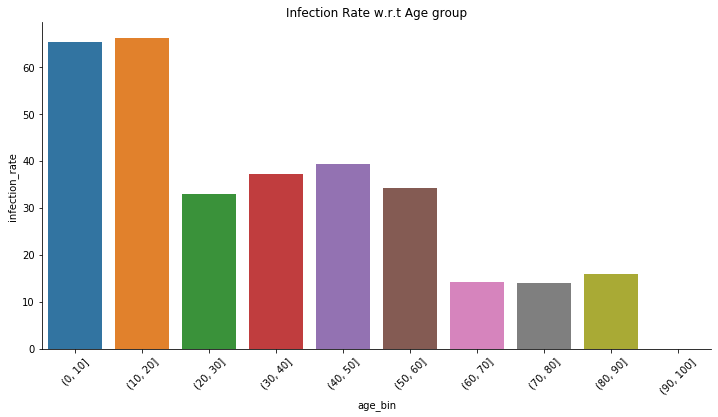

In [43]:
# visualize to check variation
plt.figure(figsize=(12,6))
ax = sns.barplot(x="age_bin", y="infection_rate", data=final)
plt.xticks(rotation=45)
sns.despine()
plt.title('Infection Rate w.r.t Age group')

Text(0.5, 1.0, 'Mortality Rate w.r.t Age group')

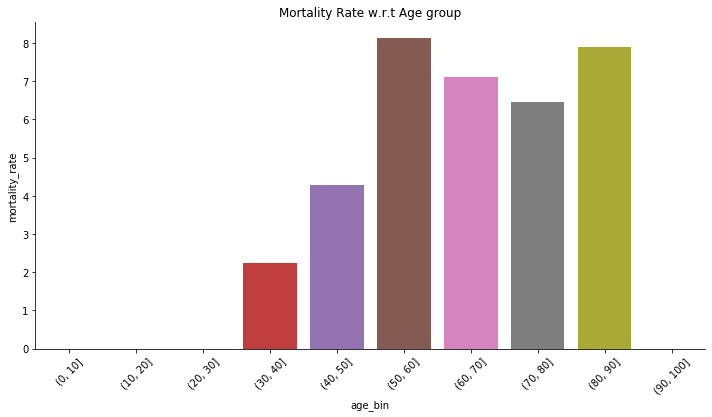

In [44]:
# visualize to check variation
plt.figure(figsize=(12,6))
ax = sns.barplot(x="age_bin", y="mortality_rate", data=final)
plt.xticks(rotation=45)
sns.despine()
plt.title('Mortality Rate w.r.t Age group')

#### Q5: Visualize the number of individuals at a location on a geographical map. (COMPLEX: Can be done with Tableau, Plotly)

Idea is to aggegate data using spark and then use Power BI to visualize

Assumption: Better way will be to have date/time wise geographical distribution of people, so considering datetime

In [45]:
geographical_counts = df.select(['Date_Time', 'lon', 'lat', 'id']).groupBy(['Date_Time', 'lon', 'lat']).agg(countDistinct('id').alias('people')).toPandas()

In [46]:
geographical_counts.to_csv('geographical_counts.csv', index=False)

In [47]:
geographical_counts.shape

(2059292, 4)

<img src='Capture.png'>